In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json
import functools
from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial
from sklearn import decomposition, preprocessing

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'RdPu_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'Wistia', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values

metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
cell_nuc.loc[cell_nuc['n_bot'] == 1, 'n_bot'] = 0
cell_nuc.loc[cell_nuc['n_top'] == 61, 'n_top'] = 65

transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
Cs = dict(zip(Genes, ['#56b4e9','#cc79a7']))
Ms = dict(zip(Genes, ['D','s']))
Ps = dict(zip(Genes, ['Blues_r','PuRd_r']))
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

N_nuclear = np.zeros((len(metacell), len(Genes)), dtype=int)
for i,gidx in enumerate(Genes):
    rawlocs = pd.read_csv('../Bacteria Info for Erik/'+transcriptomes[gidx]+'.txt', sep='\t')
    rawlocs = rawlocs[rawlocs['L'] == 'n']
    N_nuclear[:,i], _ = np.histogram( label[rawlocs['Y'], rawlocs['X']], bins=range(1,cellnum+2))

N_nuclear = pd.DataFrame(N_nuclear, columns=['N_nuclear_'+g for g in transcriptomes[Genes]], index=metacell.index)
rho_nuclear = pd.DataFrame(index=metacell.index)
for gidx in Genes:
    rho_nuclear['rho_nuclear_'+transcriptomes[gidx]] = N_nuclear['N_nuclear_'+transcriptomes[gidx]]/metacell['nuclei_area'].values
rho_nuclear = rho_nuclear.replace(np.nan, 0)
N_nuclear = N_nuclear.join(rho_nuclear).iloc[:, [0,2,1,3]]

Detected 2937 cells
Detected 1365 nuclei


# Bring in persistence images to the party

In [3]:
level = 'sub'
normtype = 'both'
stepsize = 3
bw = 25
SCALE = 32

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]



Initial number of life-birth pairs	: 69430

No. of diagrams s.t. H_k had the most persistent component
H_0:	56 [ 3.1% ]
H_1:	137 [ 7.5% ]
H_2:	1643 [ 89.5% ]

Will focus just on dimension k = 2



# Loadings

In [4]:
cidx = 2529

cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=True)
s_ = (np.s_[cextent[2]:cextent[3]], np.s_[cextent[0]:cextent[1]])
edt = ndimage.distance_transform_edt(label[s_] == cidx)
axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)

outs = ~outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')
zfactor = np.divide(  list(map(len, axes))[::-1][1:] , np.asarray(cell.shape) )
alpha = min([1.5*int(4e6/cell.size)/100, 0.8])

hcoords, hkde = [ [] for _ in range(2) ]

for gidx in Genes:

    cmask = label[ translocs[gidx]['Y'], translocs[gidx]['X'] ] == cidx
    coords = translocs[gidx].iloc[cmask].values.T
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(coords)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
       
    hkde.append( kde.copy() * ratios[invGenes[gidx]][invCells[cidx]] )
    hcoords.append(coords)

loc_kmax = max(map(np.max, hkde))

In [28]:
no_kbins = [5, 7, 17]

hzoom = []
hsummary = [ [] for _ in range(len(Genes)) ]
lsummary = [ np.zeros((len(no_kbins), 2)) for _ in range(len(Genes))]

for k in range(len(no_kbins)):
    kbins = np.linspace(0, np.max(edt), no_kbins[k])
    cellhist = np.zeros_like(cell)
    for i in range(len(kbins)-1):
        cellhist[ (edt > kbins[i]) & (edt <= kbins[i+1]) ] = i + 1
    zoom = ndimage.zoom(cellhist, zfactor, mode='grid-constant', grid_mode=True)
    hzoom.append(zoom)

    for i in range(len(Genes)):
        
        summary = np.zeros(len(kbins) - 1 )
        for hlevel in range(1, len(kbins)):
            summary[hlevel-1] = np.average(np.hstack([ hkde[i][j ,  (zoom == hlevel) & outs[j] ] for j in range(len(outs)) ]))
        summary = summary/kmax
    
        hsummary[i].append(summary)
        lsummary[i][k, 0] = summary[0]-summary[-1]
        lsummary[i][k, 1] = (summary[0]-summary[-1])/summary[0]

loc_smax = max([ max(map(np.max, hsummary[i])) for i in range(len(hsummary)) ])

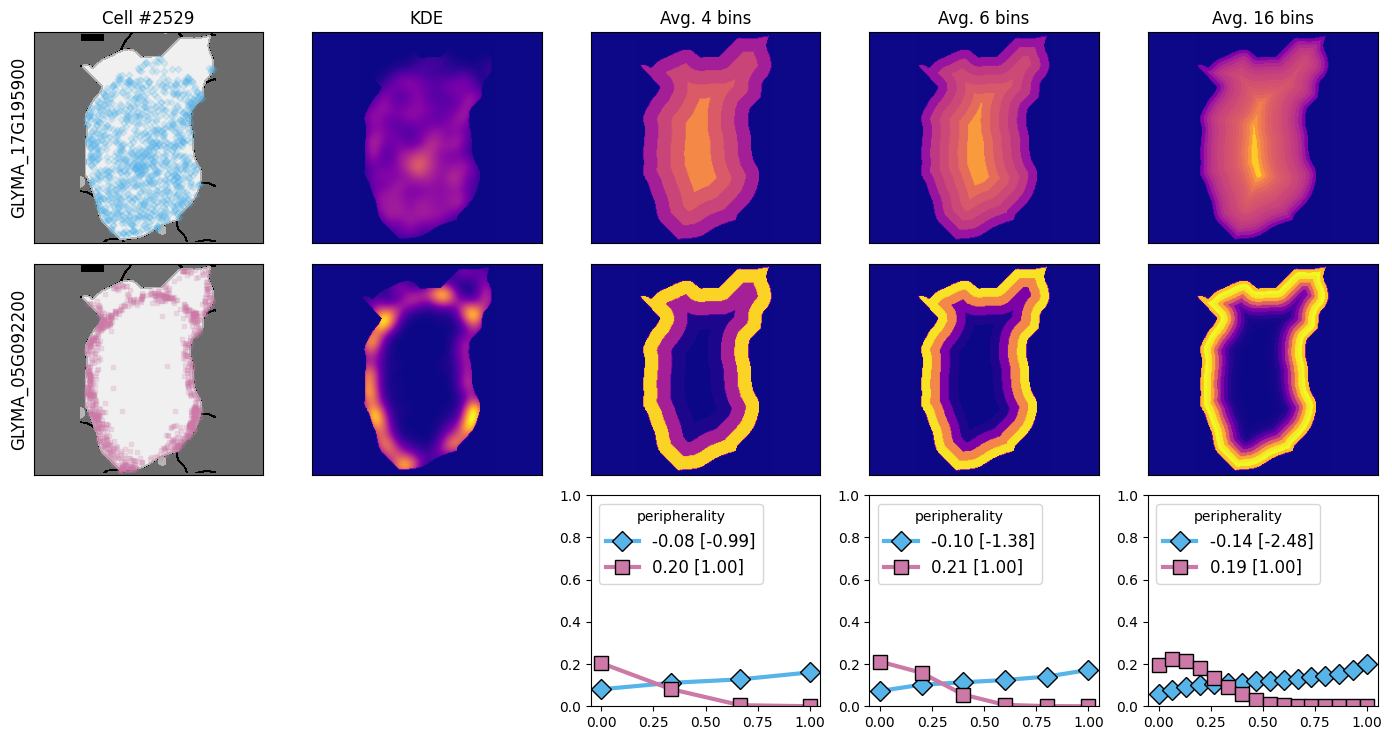

In [49]:
fig, ax = plt.subplots(3, 2+len(no_kbins), figsize=(14, 7.5), sharex=False, sharey=False)

for i in range(len(Genes)):
    j = 0
    ax[i,j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
    ax[i,j].scatter(*(hcoords[i][:2]), color=Cs[Genes[i]], marker=Ms[Genes[i]], alpha=alpha, s=int(4e6/cell.size))
    ax[i,j].set_facecolor(wong[2])

    j += 1
    ax[i,j].imshow(np.max(hkde[i], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=loc_kmax, zorder=1)
    ax[i,j].set_facecolor( mpl.colormaps[ Cmap ](0) )

    for j in range(len(no_kbins)):
        temp = np.zeros(kde.shape[1:])
        for k in range(1, no_kbins[j]):
            temp[hzoom[j] == k] = hsummary[i][j][k-1]

        ax[i,2+j].imshow(temp, origin='lower', cmap=Cmap, vmin=0, vmax=loc_smax)
        ax[i,2+j].set_facecolor( mpl.colormaps[ Cmap ](0) )

ax[0,0].set_title('Cell #{}'.format(cidx), fontsize=fs)
ax[0,1].set_title('KDE', fontsize=fs)

for i in range(len(no_kbins)):
    ax[0,2+i].set_title('Avg. {} bins'.format(no_kbins[i]-1), fontsize=fs)
    for j in range(len(Genes)):
        ll = '{:.2f} [{:.2f}]'.format(*lsummary[j][i])
        ax[2,2+i].plot(np.linspace(0,1,no_kbins[i]-1), hsummary[j][i], label=ll,
                       color=Cs[Genes[j]], lw=3, marker=Ms[Genes[j]], ms=10, mec='k', mew=1)
        ax[2,2+i].set_ylim(0, 1)

for i in range(2):
    ax[i,0].set_ylabel(transcriptomes[Genes[i]], fontsize=fs)
for ix in [(2,0), (2,1)]:
    fig.delaxes(ax[ix])
for i in range(len(no_kbins)):
    ax[2,2+i].legend(loc='upper left', fontsize=12, title='peripherality')

for a in ax.ravel()[:10]:
    a.set_aspect('equal','datalim')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout()
#plt.savefig('cell{}_periphery_analyses.png'.format(cidx), dpi=dpi, bbox_inches='tight', format='png')

In [46]:
np.linspace(0,1,no_kbins[i])

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [54]:
i,j = 0,0
linregress = stats.linregress(np.linspace(0,1,no_kbins[i]-1), hsummary[j][i])
print(linregress.slope, linregress.intercept, linregress.slope + linregress.intercept, sep='\t')

0.07696691185401644	0.08147195917259087	0.1584388710266073


In [55]:
i,j = 1,0
linregress = stats.linregress(np.linspace(0,1,no_kbins[i]-1), hsummary[j][i])
print(linregress.slope, linregress.intercept, linregress.slope + linregress.intercept, sep='\t')

0.08930406370192549	0.07630220554350373	0.1656062692454292


In [56]:
i,j = 2,0
linregress = stats.linregress(np.linspace(0,1,no_kbins[i]-1), hsummary[j][i])
print(linregress.slope, linregress.intercept, linregress.slope + linregress.intercept, sep='\t')

0.10661808529428464	0.06872860272886774	0.1753466880231524


In [40]:
4*linregress.slope + linregress.intercept

0.1584388710266073

In [37]:
16*linregress.slope + linregress.intercept

0.1753466880231524

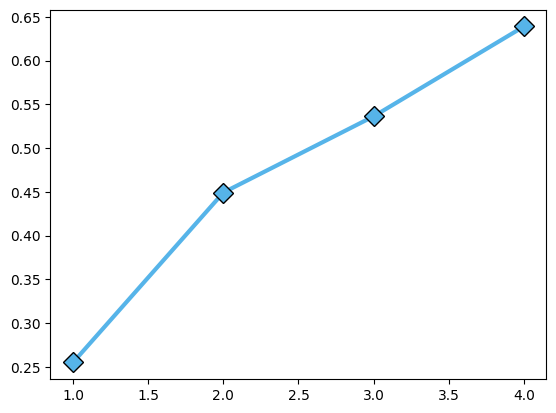

In [76]:
i = 0

plt.plot(range(1, no_kbins[i]), hsummary[0][i], color=Cs[Genes[0]], lw=3, marker=Ms[Genes[0]], ms=10, mec='k', mew=1)

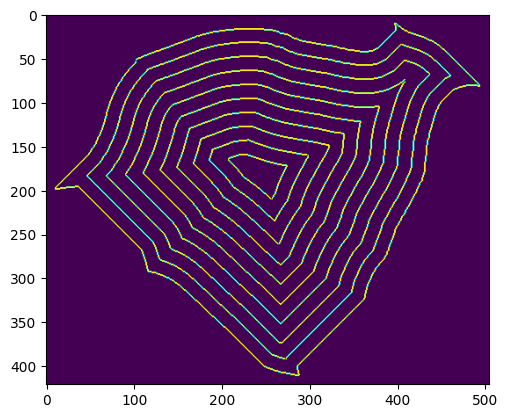

In [225]:
plt.imshow(magnitude)

In [212]:
np.unique(np.sqrt(sobel_h**2 + sobel_v**2))

array([0.        , 1.41421356, 2.        , 2.82842712, 3.16227766,
       4.        , 4.24264069, 4.47213595])

In [151]:
summary = pd.DataFrame(summary, columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 
                       index=range(1,len(kbins))).astype({'count':int})
summary

,count,mean,std,min,25%,50%,75%,max
1,80014,0.147944,0.070709,0.000000,0.096191,0.141035,0.193935,0.351713
2,67034,0.128926,0.067674,0.014951,0.076832,0.113943,0.168425,0.346143
3,51150,0.046118,0.031719,0.002603,0.023212,0.038568,0.060578,0.263788
4,37664,0.010719,0.007858,0.000277,0.004978,0.008590,0.014400,0.056187
5,24288,0.007620,0.005340,0.000000,0.003390,0.006875,0.011083,0.023632
6,10010,0.007095,0.006506,0.000000,0.000000,0.005968,0.011778,0.024121


In [119]:
pd.Series(hkde[:,  zoom == hlevel ].ravel()).describe().index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')